# Bayesian Generalized Linear Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

# Generalized Linear Models (GLM)

A Generalized Linear Model (GLM) is a blanket term for many of our standard linear models in statistics. The methodology allows for the assignment of arbitrary distributions to response variables, encompassing both linear and logistic regression as well as allowing to create Bayesian models of these classical ideas.

There are a number of packages in the Python ecosystem that are used heavily for statistical modeling. Among these are `statsmodels`, `scipy`, and `scikit-learn` for the implementation and validation of models and `pandas` for the data-handling side of things. The focus of this chapter is Bayesian modeling in Python, specifically applied to problems that we have already seen in the context of the aforementioned packages. We discuss why a Bayesian approach is a reasonable one to take and show examples of GLM implementation in PyMC3, a probabilistic programming package for defining intuitive models in Python. We start with a basic Bayesian linear regression model, explaining the theory, and build up into a hierarchical linear regression model [and some probabilistic machine learning]

## Probabilistic Programming

What is Probabilistic Programming? What is Bayes rule? Quick Overview.

## Linear Regression

Linear regression is a standard quantitative tool in every statistician's toolbox. It provides a simple, easy-to-understand framework for expressing a linear relationship between dependent and independent variables and can be readily applied in many situations. A linear regression takes the form of:

$$ Y = X\beta + \epsilon $$

Where $Y$ is the dependent variable, $X$ is our independent variable, $\beta$ are the coefficients for each feature in $X$, and $\epsilon$ is our error, assumed to be normally-distributed.

There are several ways to fit the coefficients. We typically use either Ordinary Least Squares (OLS) or Maximum Likelihood Estimation (MLE).

## Probabilistic Regression

The purpose of this chapter is to define a Bayesian, probabilistic linear regression method for easy use in Python. To this end, we will be using PyMC3, but it is good to review the basic theory of what we are dealing with. To reformulate this basic linear regression with a Bayesian methodology, we say that:

$$ Y \sim \mathcal{N}(X\beta, \sigma^2) $$

With Bayesian inference, a key component is that we define the pieces of our model as probability distributions. This makes our dependent variable a probability distribution as well. In this case, we are assuming that $Y$ is normally-distributed. The mean of this distribution is our linear value $X\beta$, while the variance is $\sigma^2$ (the variance of our error from the original model).

## Advantages of the Bayesian Approach

At the core, both the frequentist and Bayesian approaches try to get at the same solution. They only differ in how they go about it. By incorporating Bayesian statistics into our methodology, we allow for the inclusion of prior distributions. Priors allow us to include how we think our parameters are related into our model. 

In addition, our $\beta$ values in a Bayesian approach are themselves complete posterior distributions instead of point estimates. A point estimate will have a confidence interval, but an entire probability distribution provides us with a much more robust understanding of the uncertainty associated with our regression parameters.

## Defining a Toy Example

Let's generate some simple data for use with our new approach. Toy examples are always a little boring, but it is important to understand the basic approach before we get into a real world problem.

In [3]:
N = 100
intercept = 1
slope = 2

x = np.linspace(0, 1, N)
true_line = intercept + slope*x
y = true_line + np.random.normal(0, 0.5, size=N)

data = dict(x=x, y=y)

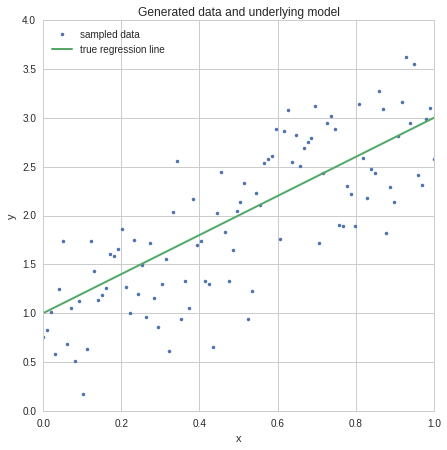

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The data points in this scatter plot are our observed information about the true relationship between $x$ and $y$. This observed information contorts our initial impressions of how our parameters are distributed into our posterior distributions.

## Creating Our Model

Let's define our priors for the Bayesian model. With PyMC3, it is remarkably easy to lay out which components of the model will follow which distributions, however, this may be confusing if you are unfamiliar with the Bayesian framework. The typical model definition is laid out here. In PyMC3, we define all of our variables using the `with` context.

In [5]:
with pm.Model() as model:
    # Defining priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    x_beta = pm.Normal('x', mu=0, sd=20)
    
    # Defining likelihood
    likelihood = pm.Normal('y', mu=(intercept + x_beta * x), sd=sigma, observed=y)
    
    # Running Inference
    start = pm.find_MAP() # Calculate a starting point
    step = pm.NUTS(scaling=start) # Define our sampling method
    trace = pm.sample(2000, step=step, start=start) # Draw 2000 samples!

Applied log-transform to sigma and added transformed sigma_log_ to model.
100%|██████████| 2000/2000 [00:01<00:00, 1210.45it/s]


If you are less familiar with probabilistic programming, this may look like a lot of nonsense. The syntax for defining probability distributions is intuitive, but this is a lot of extra buzz around the implementation of a basic linear regression. 

For this reason, the PyMC3 developers introduced a `glm` module to simplify the definition of Generalized Linear Models (GLM), including linear regressions such as ours.

In [6]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step=step, start=start)

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:01<00:00, 1325.06it/s]


## Basic Diagnostics

We have a few basic things to examine after fitting a Bayesian model. Here are the plots that show our posterior distributions as well as our traceplots: 

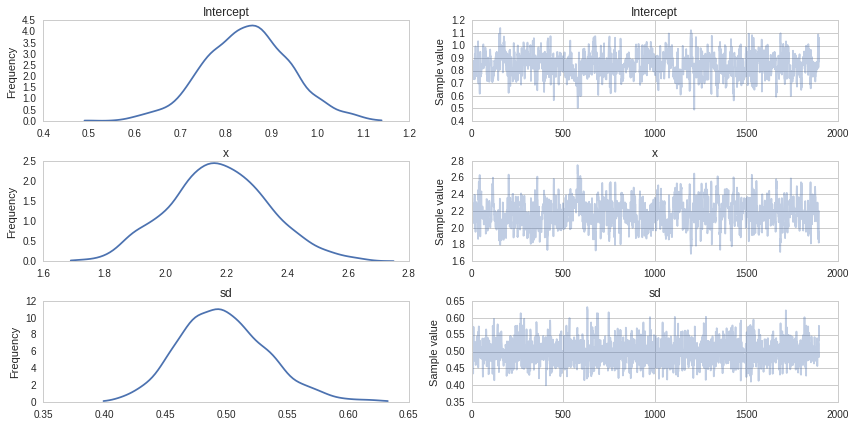

In [22]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

The posterior distributions on the left show how the various components of our regression are distributed after incorporating the observed data.

The traceplots on the right show us whether our traces have converged. The risk with our sampling methods is that we may end up with a bunch of junk values before we have proper samples of the posterior distribution. This is why we only looked at samples *after* the first one hundred, in this case. This is called a **burn-in period**. A non-stationary trace indicates that we need a longer burn-in period.

What's nice here is that the means of our posterior distributions are fairly close to the values that we used to generate the data.

In [8]:
print('Means')
print('Intercept: ', trace[100:]['Intercept'].mean())
print('x_beta: ', trace[100:]['x'].mean())
print('sd: ', trace[100:]['sd'].mean())

Means
Intercept:  0.846561941964
x_beta:  2.17662312871
sd:  0.497784078983


In addition to the trace, we can also examine the highest posterior density (HPD) interval of each parameter. The HPD is a type of **credible interval**, a Bayesian interval estimate. If a parameter has a probability of $0.95$ to lie within a particular interval, then that interval is a $95\%$ credible interval. In particular, we define the $95\%$ HPD interval such that it is the narrowest credible interval. This tends to select the values that have the highest probability density. There are other informative credible intervals, such as the **equal-tailed interval**, where the probability of being below the interval is equal to the probability of being above it

In [23]:
HPD = pm.stats.hpd(trace)

Instead of drawing a single line as with the frequentist approach, here we have a "distribution" of regression lines. We plot our possibilities by examining the posterior predictive distribution. This simply entails sampling from our calculated posteriors and drawing regression lines using this new set of samples.

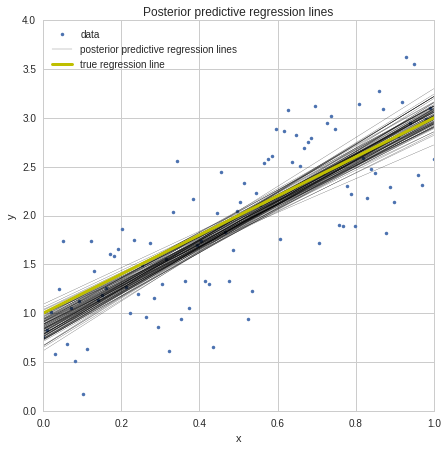

In [9]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

## Handling Outliers

Let's make our data set a little weirder. Maybe.

In [ ]:
# T Distribution

## Logistic Regression

Extending logistic regression to work within a Bayesian framework is similarly simple in PyMC3. Logistic regression is a fan favorite method for classification and is applied in many different situations. It is easy to understand, like linear regression, which likely is a large part of its longetivity in the face of so many powerful machine learning classifiers.

# Introducing Hierarchical Regression

Let's explore how we could handle a dataset with multiple related componenets. In the stock market, everything exists under the same umbrella, whether we are willing to admit this or not. An incredibly common concept in both fundamental and quantitative finance is the idea of market beta. The market beta of a security is a measure of its exposure to the change in the market. A common way to compute it is to use a linear regression:

$$ R_S = \alpha + \beta_M * R_M + \epsilon $$

Where $R_S$ is the return of your chosen security and $R_M$ is the returns of the market. We want to come up with an estimate, $\hat{\beta}_M$. We generally use the returns of SPY, an ETF that tracks the S&P 500, as our market benchmark.

Here is some code to pull the pricing data that we want:

In [39]:
import datetime
import collections
import ystockquote as ysq
import pandas_datareader.data as web
import pandas as pd
import numpy as np

stocks = ['SPY', 'GOOG', 'TSLA', 'AAPL', 'AMZN']

start_date = "2012-09-01"
end_date = "2015-04-27"

close_prices = pd.DataFrame()

for stock in stocks:
    x = web.DataReader(stock, 'yahoo', start_date, end_date)['Close']
    x.name = stock
    close_prices[stock] = x
    
returns = close_prices.pct_change()[1:]

And this is what our returns data looks like:

In [40]:
returns.head()

,SPY,GOOG,TSLA,AAPL,AMZN
Date,,,,,
2012-09-05,-0.000851,-0.000470,-0.007107,-0.007022,-0.006697
2012-09-06,0.020297,0.027442,0.021832,0.009012,0.020957
2012-09-07,0.003895,0.009651,0.028021,0.006166,0.030870
2012-09-10,-0.005681,-0.007619,-0.067462,-0.026013,-0.007911
2012-09-11,0.002787,-0.012244,0.015711,-0.003244,-0.005523


Now that we have our data, we have a few different options for constructing our model.

## Do it all together!

We can pool all of our returns data together by envisioning a portfolio that holds equal amounts of the specified securities and estimate the market beta of this portfolio with a single regression.

## Do it all separately!

We can treat each security in our list as an entity totally independent of the others. 

## Do a bit of both!

## Why Hierarchical Regression?

Hierarchical sounds super buzzword-y

There are many situations in real life that lend themselves to a hierarchical regression. 

We have a few different options for implementing something of this nature.

## Cool, let's use real data

For our example of hierarchical regression, let's use a classic finance example, calculating historical market beta. 

Let's pull prices for a few stocks in the tech industry as well as the S&P500.

We can estimate individual regressions for each stock to calculate their market beta or we can make it hierarchical.

## Non-linear Models